In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model, model_from_json
import os
import matplotlib.pyplot as plt
import glob
import numpy as np

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 64, 64

#Location of the images
train_data_dir = '../train'
val_data_dir = '../validation'
nb_epochs = 8
batch_size = 16
FC_SIZE = 256
NB_IV3_LAYERS_TO_FREEZE = 172

input_shape = (img_width, img_height, 3)

In [3]:
def get_no_files(dir):
    if not os.path.exists(dir):
        print("Error: Invalid directory")
        #TO DO: Error Handling
        return 0
    count = 0
    for r, dirs, files in os.walk(dir):
        for dr in dirs:
            count += len(glob.glob(os.path.join(r, dr + "/*")))
    return count

In [4]:
def freeze_all_layers(base_model):
    for layer in base_model.layers:
        layer.trainable=False
    

In [5]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(FC_SIZE, activation='elu')(x) #new FC layer, random init
    x = Dense(FC_SIZE, activation='elu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(inputs=base_model.input, outputs=predictions)
    return model    

In [6]:

nb_train_samples = get_no_files(train_data_dir)
nb_classes = len(glob.glob(train_data_dir + "/*"))
nb_val_samples = get_no_files(val_data_dir)
nb_epochs = int(nb_epochs)
batch_size = int(batch_size)

# data prep
train_datagen =  ImageDataGenerator()
val_datagen = ImageDataGenerator(
    """preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True"""
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

validation_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)



Found 4630 images belonging to 12 classes.
Found 120 images belonging to 12 classes.


In [8]:
# setup model
base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False) #include_top=False excludes final FC layer
freeze_all_layers(base_model)
model = add_new_last_layer(base_model, nb_classes)

# transfer learning

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

"""history_tl = model.fit_generator(
    train_generator,
    nb_epoch=nb_epochs,
    steps_per_epoch=None,
    validation_data=validation_generator,
    nb_val_samples=nb_val_samples,
    class_weight='auto') 
"""
history_tl = model.fit_generator( 
                                 train_generator, 
                                 steps_per_epoch=int(nb_train_samples/batch_size), 
                                 epochs=nb_epochs, 
                                 validation_data=validation_generator, 
                                 validation_steps=int(nb_val_samples/batch_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

/home/pragya/.local/lib/python2.7/site-packages/keras/preprocessing/image.py:506: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


289/289 [==============================] - 515s - loss: 2.7027 - acc: 0.4555 - val_loss: 2.3344 - val_acc: 0.4018
Epoch 2/8
289/289 [==============================] - 506s - loss: 1.1213 - acc: 0.6515 - val_loss: 1.7433 - val_acc: 0.5000
Epoch 3/8
289/289 [==============================] - 494s - loss: 0.7319 - acc: 0.7547 - val_loss: 1.7578 - val_acc: 0.4808
Epoch 4/8
289/289 [==============================] - 496s - loss: 0.5436 - acc: 0.8101 - val_loss: 1.7825 - val_acc: 0.5865
Epoch 5/8
289/289 [==============================] - 496s - loss: 0.4448 - acc: 0.8470 - val_loss: 1.6828 - val_acc: 0.5962
Epoch 6/8
289/289 [==============================] - 496s - loss: 0.3636 - acc: 0.8816 - val_loss: 2.2709 - val_acc: 0.5288
Epoch 7/8
289/289 [==============================] - 495s - loss: 0.3321 - acc: 0.8909 - val_loss: 2.2578 - val_acc: 0.5385
Epoch 8/8
289/289 [==============================] - 496s - loss: 0.3067 - acc: 0.9005 - val_loss: 2.5950 - val_acc: 0.5577


In [9]:
#Save the model

# serialize model to JSON
model_json = model.to_json()
with open("plantSeed.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("plantSeed.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
# load json and create model
json_file = open('plantSeed.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("plantSeed.h5")
print("Loaded model from disk")

Loaded model from disk


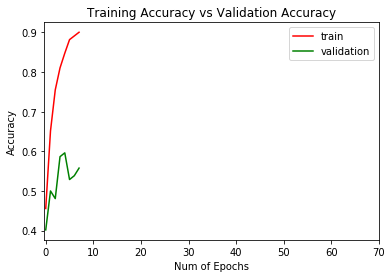

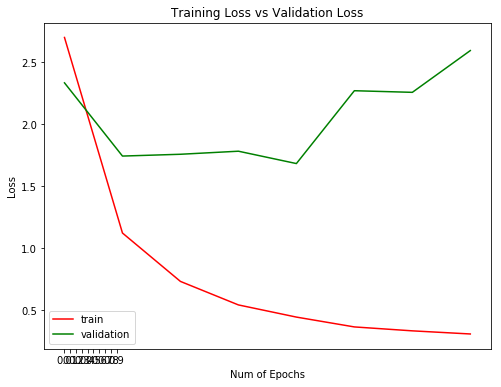

In [11]:
h=history_tl

plt.figure(0)
plt.plot(h.history['acc'],'r')
plt.plot(h.history['val_acc'],'g')
plt.xticks(np.arange(0, 80, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(h.history['loss'],'r')
plt.plot(h.history['val_loss'],'g')
plt.xticks(np.arange(0, 1, 0.10))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
 
plt.show()